In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CEVAE import *
from cevaetools import *
from lineartoydata import *
from lineargaussian_analytical_methods import *
from binary_analytical_methods import *
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
main_folder = "linear_data_tests_appendix"

In [318]:
# Load data gen parameters
sub_folder_params = "params3"
[c_x, c_t, c_yz, c_yt, s_x, s_t, s_y] = load_dataparameters(main_folder, sub_folder_params)
print(c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)

[-1.57882027  0.79555286] [-0.81765226] [0.98890266] [-1.13034777] [1.27598139 0.86828711] [1.04058315] [0.76975766]


In [37]:
data_sub_folder = sub_folder_params + "data500to20000"
param_times = 10
dfs, datasets = load_dfs(main_folder, data_sub_folder, param_times=param_times)
datasize = sorted([int(ds) for ds in dfs.keys()])

In [38]:
device="cpu"

num_epochs=100
lr_start=0.01
lr_end=0.001
z_dim=10
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30
t_mode=0
y_mode=0
x_mode=np.array([0,0])
x_dim = 2
ty_separate_enc=False
z_mode=0
common_stds = False
x_loss_scaling = 1

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]
labels = [str(dsize) for dsize in datasize]

sub_folder_model = sub_folder_params + "data500to20000NNmodels"
models_NN, losses_NN = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

In [39]:
num_epochs=100
lr_start=0.01
lr_end=0.01
z_dim=1
p_y_zt_nn_layers=0
p_y_zt_nn_width=30
p_t_z_nn_layers=0
p_t_z_nn_width=30
p_x_z_nn_layers=0
p_x_z_nn_width=30
q_z_nn_layers=0
q_z_nn_width=30
t_mode=0
y_mode=0
x_mode=np.array([0,0])
x_dim = 2
ty_separate_enc=False
z_mode=0
common_stds = True
x_loss_scaling = 1

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

sub_folder_model = sub_folder_params + "data500to20000linearmodels"
models_linear, losses_linear = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

In [40]:
AID_NN = np.zeros((param_times, len(labels)))
AID_linear = np.zeros((param_times, len(labels)))

gothrough = [(AID_NN, models_NN),(AID_linear, models_linear)]
#gothrough = [(AID_NN, models_NN)]
#gothrough = [(AID_linear, models_linear)]
for AID_,models_ in gothrough:
    for i,label in enumerate(labels):
        print(label)
        for j in range(param_times):
            AID_[j,i] = estimate_AID_lineardata(models_[label][j], c_yt, 
                            c_yz, s_y, c_t, s_t, c_x, n=100, lim=6, nsample=10000)[0]

500
1000
2000
5000
10000
15000
20000
500
1000
2000
5000
10000
15000
20000


In [41]:
AID_analytical = np.zeros((param_times,len(labels)))
for i in range(len(labels)):
    for j in range(param_times):
        cov = cov_from_df(dfs[labels[i]][j])
        est_c_yt = analytical_cyt_estimate(cov)
        est_c_yz = np.sqrt(analytical_cyzsquared_estimate(cov))
        est_s_y = analytical_sy_estimate(cov)
        AID = analytical_method_AID(est_c_yz, est_c_yt, est_s_y, c_yt, c_yz, s_y, c_t, s_t)[0]
        AID_analytical[j,i] = AID

## AID convergence plot

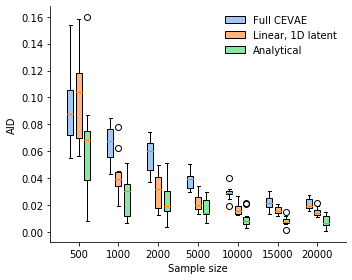

In [42]:
plt.figure(figsize=(5,4))
palette = sns.color_palette("pastel")#plt.get_cmap('Set3')
places = list(range(len(labels)))
width = 0.15
diff = 0.21
for i in range(len(labels)):
    bplot1 = plt.boxplot(AID_NN[~np.isnan(AID_NN[:,i])][:,i], positions=[places[i]-diff*1], widths=[width],patch_artist=True)
    bplot2 = plt.boxplot(AID_linear[~np.isnan(AID_linear[:,i])][:,i], positions=[places[i]-diff*0], widths=[width],patch_artist=True)
    #bplot3 = plt.boxplot(AID_linear_zdim2[~np.isnan(AID_linear_zdim2[:,i])][:,i], positions=[places[i]+diff*0.5], widths=[width],patch_artist=True)
    bplot4 = plt.boxplot(AID_analytical[:,i], positions=[places[i]+diff*1],widths=[width],patch_artist=True)
    colors = [palette[num] for num in range(4)]
    for j,bplot in enumerate([bplot1,bplot2,bplot4]):
        for patch in bplot['boxes']:
            patch.set_facecolor(colors[j])
plt.xticks(places, datasize)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
custom_lines = [Patch(facecolor=palette[i], edgecolor='black') for i in range(4)]
plt.legend(custom_lines, ["Full CEVAE", "Linear, 1D latent", "Analytical"], frameon=False)
plt.xlabel("Sample size")
plt.ylabel("AID")

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.savefig("Figures/publication/supplementart_linGan_convergence_params?.png", bbox_inches = 'tight',
    pad_inches = 0.1)
plt.tight_layout()
plt.show()

# Binary data

In [131]:
main_folder = "binary_data_tests_appendix"

In [153]:
sub_folder_params = "params1"
[z_probs,x_probs,t_probs,y_probs] = load_dataparameters(main_folder, sub_folder_params)
print(z_probs)
print(x_probs)
print(t_probs)
print(y_probs)
estimate_true_py_dot(z_probs,y_probs)

[0.51240153 0.48759847]
[[[0.75545065 0.24454935]
  [0.4718047  0.5281953 ]]

 [[0.26506763 0.73493237]
  [0.3694143  0.6305857 ]]]
[[0.55896021 0.44103979]
 [0.70524749 0.29475251]]
[[[0.57703665 0.42296335]
  [0.8759038  0.1240962 ]]

 [[0.48439923 0.51560077]
  [0.84653151 0.15346849]]]


array([[0.53186679, 0.46813321],
       [0.86158192, 0.13841808]])

In [154]:
(z_probs[:,None]*t_probs).sum(0)
(z_probs[:,None,None]*y_probs*t_probs[:,:,None]).sum(0) / (z_probs[:,None]*t_probs).sum(0)[:,None]

array([[0.52649492, 0.47350508],
       [0.86448564, 0.13551436]])

In [115]:
data_sub_folder = sub_folder_params + "data3000to80000"
param_times = 10
dfs, datasets = load_dfs(main_folder, data_sub_folder, param_times=param_times)
datasize = sorted([int(ds) for ds in dfs.keys()])

data_sub_folder_extra = sub_folder_params + "data3000to80000_additional"
param_times_extra = 40
dfs_extra, datasets_extra = load_dfs(main_folder, data_sub_folder_extra, param_times=param_times_extra)
datasize = sorted([int(ds) for ds in dfs.keys()])

In [116]:
device = 'cpu'

num_epochs=300
lr_start=0.01
lr_end=0.0005
z_dim=10
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30
t_mode=2
y_mode=2
x_mode=np.array([2,2])
x_dim = 2
ty_separate_enc=False
z_mode=0
common_stds = False
x_loss_scaling = 1

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]


labels = [str(dsize) for dsize in datasize]
sub_folder_model = sub_folder_params + "data3000to40000NNmodels"

models_NN, losses_NN = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

In [324]:
device = 'cpu'

num_epochs=300
lr_start=0.01
lr_end=0.0005
z_dim=1
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30
t_mode=2
y_mode=2
x_mode=np.array([2,2])
x_dim = 2
ty_separate_enc=False
z_mode=2
common_stds = False
x_loss_scaling = 1

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]


labels = [str(dsize) for dsize in datasize]
sub_folder_model = sub_folder_params + "data3000to40000NNmodelsbinaryz"

models_NN_binaryz, losses_NN_binaryz = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

In [117]:
bAID_NN = np.zeros((param_times, len(labels)))
#AID_NN_binaryz = np.zeros((param_times, len(labels)))

#gothrough = [(AID_NN, models_NN),(AID_NN_binaryz, models_NN_binaryz)]
gothrough = [(bAID_NN, models_NN)]
for AID_,models_ in gothrough:
    for i,label in enumerate(labels):
        print(label)
        for j in range(param_times):
            AID_[j,i] = estimate_AID(models_[label][j],z_probs,t_probs,y_probs,n=10000)

3000
5000
10000
15000
20000
30000
40000
60000
80000


In [118]:
# analytical AIDs
from binary_analytical_methods import *
AID_miao = np.zeros((param_times+param_times_extra,len(labels)))
py_dots_miao = np.zeros((param_times+param_times_extra,len(labels),2))
for i, label in enumerate(labels):
    print(label)
    for j in range(param_times):
        py_dot1, py_dot0 = analytical_miao_pydot(dfs[label][j])
        py_dot_miao = np.array([[1-py_dot0.item(), py_dot0.item()],[1-py_dot1.item(), py_dot1.item()]])
        py_dots_miao[j,i,:] = np.array([py_dot0.item(),py_dot1.item()])
        AID_miao[j,i] = estimate_AID_from_py_dot(py_dot_miao, z_probs, t_probs, y_probs)
    for j in range(param_times, param_times + param_times_extra):
        py_dot1, py_dot0 = analytical_miao_pydot(dfs_extra[label][j-param_times])
        py_dot_miao = np.array([[1-py_dot0.item(), py_dot0.item()],[1-py_dot1.item(), py_dot1.item()]])
        py_dots_miao[j,i,:] = np.array([py_dot0.item(),py_dot1.item()])
        AID_miao[j,i] = estimate_AID_from_py_dot(py_dot_miao, z_probs, t_probs, y_probs)

3000
5000
10000
15000
20000
30000
40000
60000
80000


In [119]:
true_pydot = estimate_true_py_dot(z_probs,y_probs)[:,1]

In [120]:
pyzt1 = dfs['40000'][1][dfs['40000'][1]['t']==1].groupby('z').agg(['count','mean'])['y']
pydot1 = (pyzt1['mean'] * z_probs).sum()
pyzt0 = dfs['40000'][1][dfs['40000'][1]['t']==0].groupby('z').agg(['count','mean'])['y']
pydot0 = (pyzt0['mean'] * z_probs).sum()
print(pydot0,pydot1)

0.3959075604434732 0.9492119231320884


In [121]:
py_dots_NN = np.zeros((param_times,len(labels),2))
py_dots_binaryz = np.zeros((param_times,len(labels),2))
#gothrough = [(py_dots_NN, models_NN),(py_dots_binaryz, models_NN_binaryz)]
gothrough = [(py_dots_NN, models_NN)]
for py_dots_,models_ in gothrough:
    for i,label in enumerate(labels):
        for j in range(param_times):
            py_dot = estimate_model_py_dot(models_[label][j],n=10000)
            py_dots_[j,i,:] = py_dot[:,1]

In [94]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times"
})

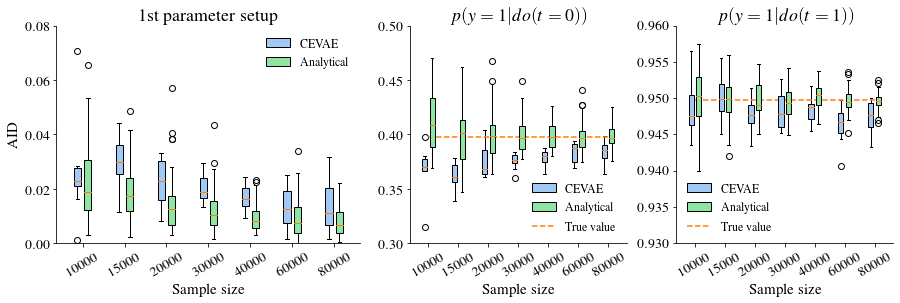

In [130]:
import seaborn as sns
show_starting_from = 2
fig, ax = plt.subplots(1,3,figsize=(15,4), gridspec_kw = {"width_ratios":[7,5,5]})
#plt.figure(figsize=(6,5))
palette = sns.color_palette("pastel")#plt.get_cmap('Set3')
places = list(range(len(labels)))
width = 0.17
diff = 0.25
for i in range(show_starting_from,len(labels)):
    bplot1 = ax[0].boxplot(bAID_NN[~np.isnan(bAID_NN[:,i])][:,i], positions=[places[i]-diff*0.5], widths=[width],patch_artist=True)
    #bplot2 = ax[0].boxplot(bAID_NN_binaryz[~np.isnan(bAID_NN_binaryz[:,i])][:,i], positions=[places[i]], widths=[width],patch_artist=True)
    bplot3 = ax[0].boxplot(AID_miao[:,i], positions=[places[i]+diff*0.5],widths=[width],patch_artist=True)
    colors = [palette[num] for num in range(4)]
    for j,bplot in [(0,bplot1),(2,bplot3)]:
        for patch in bplot['boxes']:
            patch.set_facecolor(colors[j])
            
for i in range(show_starting_from,len(labels)):
    bplot1 = ax[1].boxplot(py_dots_NN[:,i,0], positions=[places[i]-diff*0.5], widths=[width], patch_artist=True)
    #bplot2 = ax[0].boxplot(bAID_NN_binaryz[~np.isnan(bAID_NN_binaryz[:,i])][:,i], positions=[places[i]], widths=[width],patch_artist=True)
    bplot3 = ax[1].boxplot(py_dots_miao[:,i,0], positions=[places[i]+diff*0.5], widths=[width], patch_artist=True)
    colors = [palette[num] for num in range(4)]
    for j,bplot in [(0,bplot1),(2,bplot3)]:
        for patch in bplot['boxes']:
            patch.set_facecolor(colors[j])

for i in range(show_starting_from,len(labels)):
    bplot1 = ax[2].boxplot(py_dots_NN[:,i,1], positions=[places[i]-diff*0.5], widths=[width], patch_artist=True)
    #bplot2 = ax[0].boxplot(bAID_NN_binaryz[~np.isnan(bAID_NN_binaryz[:,i])][:,i], positions=[places[i]], widths=[width],patch_artist=True)
    bplot3 = ax[2].boxplot(py_dots_miao[:,i,1], positions=[places[i]+diff*0.5], widths=[width], patch_artist=True)
    colors = [palette[num] for num in range(4)]
    for j,bplot in [(0,bplot1),(2,bplot3)]:
        for patch in bplot['boxes']:
            patch.set_facecolor(colors[j])

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
custom_lines = [Patch(facecolor=palette[i], edgecolor='black') for i in (0,2)] + \
    [Line2D([0], [0], linestyle='--', color="C1")]
ax[0].legend(custom_lines, ["CEVAE", "Analytical"], frameon=False, fontsize=12)
ax[0].set_ylabel("AID", fontsize=15)
ax[0].set_title("1st parameter setup", fontsize=18)
ax[0].set_ylim(0,0.08)

ax[1].set_title("$p(y=1|do(t=0))$", fontsize=18)
ax[1].plot([places[show_starting_from],places[-1]],[true_pydot[0],true_pydot[0]],'--', color='C1')
ax[1].legend(custom_lines, ["CEVAE", "Analytical", "True value"], frameon=False, fontsize=12)
ax[1].set_ylim(0.3,.5)

ax[2].set_title("$p(y=1|do(t=1))$", fontsize=18)
ax[2].plot([places[show_starting_from],places[-1]],[true_pydot[1],true_pydot[1]],'--',color='C1')
ax[2].legend(custom_lines, ["CEVAE", "Analytical", "True value"], frameon=False, fontsize=12)
ax[2].set_ylim(0.93,.96)

"""
ax[1].plot([places[show_starting_from],places[-1]],[true_pydot[0],true_pydot[0]],'--')
ax[1].plot([places[show_starting_from],places[-1]],[true_pydot[1],true_pydot[1]],'--')
ax[1].legend(["True $p(y=1|do(t=0))$","True $p(y=1|do(t=1))$"], frameon=False, fontsize=15, loc="right",
            bbox_to_anchor=(1.03,0.5))
ax[1].boxplot(py_dots_NN[:,show_starting_from:,1], positions=places[show_starting_from:])
ax[1].boxplot(py_dots_NN[:,show_starting_from:,0], positions=places[show_starting_from:])
ax[1].set_ylabel("$p(y|do(t))$ estimate", fontsize=15)
ax[1].set_title("CEVAE", fontsize=18)

ax[2].plot([places[show_starting_from],places[-1]],[true_pydot[0],true_pydot[0]],'--')
ax[2].plot([places[show_starting_from],places[-1]],[true_pydot[1],true_pydot[1]],'--')
#ax[2].legend(["True $p(y=1|do(t=1))$","True $p(y=1|do(t=0))$"], frameon=False, fontsize=12)
ax[2].boxplot(py_dots_miao[:,show_starting_from:,1], positions=places[show_starting_from:])
ax[2].boxplot(py_dots_miao[:,show_starting_from:,0], positions=places[show_starting_from:])
ax[2].set_ylabel("$p(y|do(t))$ estimate", fontsize=15)
ax[2].set_title("Analytical method", fontsize=18)
ax[2].set_ylim(0.3,1)"""

for i in range(3):
    ax[i].set_xlabel("Sample size", fontsize=15)
    ax[i].set_xticks(places[show_starting_from:])
    ax[i].set_xticklabels(datasize[show_starting_from:], fontsize=14, rotation=30)
    ax[i].tick_params(axis='y', which='major', labelsize=14)
ax[0].tick_params(axis='x', which='major', labelsize=14, rotation=30)
        
for i in range(3):
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)

#plt.tight_layout()
plt.savefig("Figures/publication/appendix_binarydataconv_params0.png", bbox_inches = 'tight',
    pad_inches = 0, dpi=200)
plt.show()

In [349]:
bplot1['boxes'][0]